In [293]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
ds=xr.open_dataset('chirps-v2_monthly_africa_2.5.nc')
df1=ds['precip'].to_dataframe().reset_index()
df=ds['precip'].to_dataframe().reset_index()
len_nan=df['precip'].isna().sum().sum()
df=df.sample(n=10000,random_state=42)
df['time']=(pd.to_datetime(df['time'])-pd.Timestamp('1981-01-01')).dt.days


In [3]:
df_notNa=df[df['precip'].notna()]
df_na=df[df['precip'].isna()]
X=df_notNa.drop(columns='precip')
Y=df_notNa['precip']


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=42)
knn=KNeighborsRegressor(n_neighbors=5)
knn.fit(x_train,y_train)


KNeighborsRegressor()

In [5]:
X_missing=df_na.drop(columns='precip')
y_pred=knn.predict(X_missing)
y_pred

array([ 86.56145 ,  29.536327,  25.461695, ...,  19.791164,  92.94685 ,
       198.20663 ], dtype=float32)

In [6]:
df1=ds['precip'].to_dataframe().reset_index()
y_pred=np.random.choice(y_pred,size=len_nan,replace=True)
df1.loc[df1['precip'].isna(),'precip']=y_pred

In [7]:
ds1=df1.set_index(['time','latitude','longitude']).to_xarray()
print(ds1['precip'])

<xarray.DataArray 'precip' (time: 519, latitude: 320, longitude: 300)> Size: 199MB
array([[[6.37316399e+01, 6.18055840e+01, 1.02691895e+02, ...,
         6.81842499e+01, 6.84054794e+01, 1.27823441e+02],
        [1.19661036e+01, 2.85887947e+01, 1.52345123e+01, ...,
         3.88851166e+01, 5.87041016e+01, 6.84277582e+00],
        [1.52070312e+02, 4.31874228e+00, 2.68814972e+02, ...,
         4.68220596e+01, 6.80317078e+01, 3.59844589e+01],
        ...,
        [5.21571541e+01, 1.05344803e+02, 1.64032345e+01, ...,
         1.65026798e+01, 1.56327276e+01, 2.16018085e+01],
        [2.60000992e+00, 1.48951508e+02, 5.87695923e+01, ...,
         1.43445959e+01, 2.04651775e+01, 2.19130135e+01],
        [1.59962280e+02, 8.63113022e+01, 6.35556145e+01, ...,
         1.68042984e+01, 2.01907616e+01, 2.20333939e+01]],

       [[2.31103733e-01, 1.90344208e+02, 6.80317078e+01, ...,
         1.14182251e+02, 7.92670670e+01, 3.19783173e+01],
        [6.32889786e+01, 1.03386436e+02, 1.48422195e+02, ...,


In [287]:
hoa_region=ds1.sel(latitude=slice(-10,12),longitude=slice(30,52))
mam_month=hoa_region.sel(time=hoa_region['time.month'].isin([3,4,5]))
base_period=mam_month.sel(time=slice('1979-01-01','2010-12-31'))
base_mean=base_period.mean(dim='time')
mam_mean_year=base_period.groupby('time.year').mean(dim='time')
#mam_mean_year_set=mam_mean_year.reindex(year=np.repeat(mam_mean_year['year'],3))
mam_anomalies=mam_mean_year-base_mean

#print(mam_anomalies['precip'])


<xarray.DataArray 'precip' (year: 30, latitude: 88, longitude: 88)> Size: 929kB
array([[[-2.63756027e+01, -2.76398926e+01, -2.87783737e+01, ...,
          1.43715668e+00, -4.40250397e+00,  2.04555435e+01],
        [-1.76559982e+01, -1.95232010e+01, -1.76713943e+01, ...,
         -6.91676331e+00,  4.28826332e+01,  1.17420502e+01],
        [-7.67194366e+00, -1.05021591e+01, -1.21984482e+01, ...,
         -1.16297493e+01, -1.65645599e-01, -3.05102291e+01],
        ...,
        [ 1.65343037e+01,  1.51101952e+01,  1.35891800e+01, ...,
         -5.14123688e+01, -2.32313881e+01, -1.27417412e+01],
        [ 1.78898869e+01,  1.62648869e+01,  1.23509026e+01, ...,
          9.40504789e-01, -1.86292458e+01, -1.02026138e+01],
        [ 1.57023945e+01,  1.35613842e+01,  8.76772881e+00, ...,
          2.49868155e+00,  5.90766869e+01, -1.72049179e+01]],

       [[-5.47669983e+00,  8.28856659e+00,  1.69116364e+01, ...,
          2.39967499e+01, -1.79270744e+01,  9.79216766e+00],
        [-1.11755371e+0

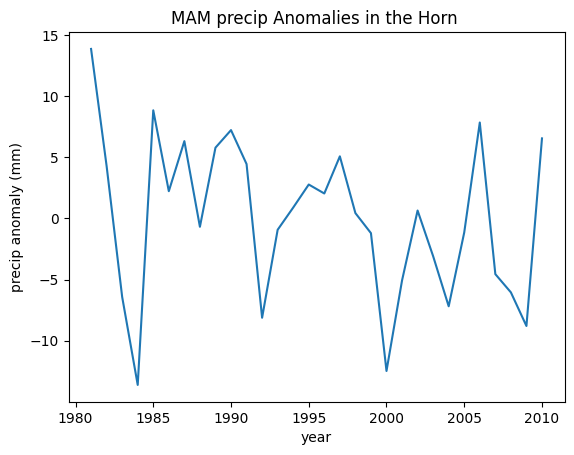

In [294]:
mam_anomalies_mean=mam_anomalies.mean(dim=['latitude','longitude'])
mam_anomalies_mean['precip'].plot()
plt.title('MAM precip Anomalies in the Horn ')
plt.xlabel('year')
plt.ylabel('precip anomaly (mm)')
plt.show()

In [296]:
df_ONI=pd.read_csv('oni_data.csv')
#print(df_ONI)
oni_data_1981_2024=df_ONI[(df_ONI['Year']>1980) & (df_ONI['Year']<2011)]['OND']

mam_anomalies1=mam_anomalies.groupby('year').mean(dim='year')
#calculateing for a point
mam_anomalies1_mean=mam_anomalies1['precip'].mean(dim=['latitude','longitude'])
mam_oni_corr=np.corrcoef(mam_anomalies1_mean,oni_data_1981_2024.values)

mam_oni_corr

array([[1.        , 0.25056402],
       [0.25056402, 1.        ]])

In [297]:
import numpy as np


print(mam_anomalies1['precip'].shape) 


corr_map = np.zeros((mam_anomalies1['precip'].shape[1], mam_anomalies1['precip'].shape[2])) 

for i in range(mam_anomalies1['precip'].shape[1]): 
    for j in range(mam_anomalies1['precip'].shape[2]): 
        
        corr_map[i, j] = np.corrcoef(mam_anomalies1['precip'][:, i, j], oni_data_1981_2024)[0, 1]
print(corr_map)

(30, 88, 88)
[[ 0.20441158  0.2056986   0.22587665 ...  0.07217847 -0.2717738
  -0.08946587]
 [ 0.20387296  0.20492258  0.19520718 ...  0.07737833  0.30425902
  -0.27836664]
 [ 0.27669513  0.20301576  0.21406515 ... -0.2100056   0.16236831
  -0.01114018]
 ...
 [ 0.04956392  0.05562226  0.07420686 ...  0.03487146  0.07657127
  -0.08654979]
 [ 0.02283456  0.04667521  0.07415942 ... -0.14884235  0.03330572
  -0.08587924]
 [ 0.04080535  0.0660882   0.05917763 ... -0.09159302 -0.1379064
  -0.45410102]]


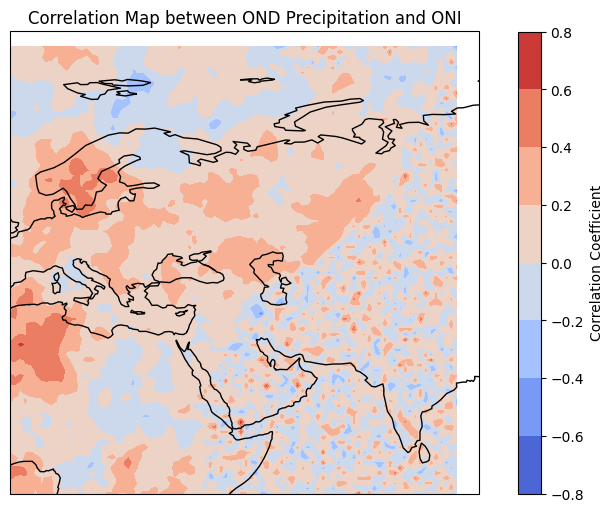

In [298]:
import cartopy.crs as ccrs
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
plt.contourf(corr_map, transform=ccrs.PlateCarree(), cmap='coolwarm')
plt.title('Correlation Map between OND Precipitation and ONI')
plt.colorbar(label='Correlation Coefficient')
plt.show()